# Changed
v4 = 0.3


# Knowledge Assembly

In [1]:
# for nellinetworkconjunctive
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)  

from nellinetworkconjunctive_proportion_v4 import Network
from helpers import fit_sigmoid, mean_squared_error, rotate, load_behavioural_data
from plotting import plotting_init, matrix_plot, mds_plot

import torch
import numpy as np
from scipy.special import expit
from sklearn import manifold
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool

## Load behavioural data

In [2]:
midd_performance, high_performers, low_performers = load_behavioural_data("../behavioural-data/")

## Set simulation mode

In [3]:
mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"

## Set Hyperparameters

In [4]:
# Random seeds
seeds_n = 10
mds_seed = 1

# Number of input items
items_n = 7

# Experiment details
training_blocks = 1
trials = 2000
training_length = training_blocks * trials
# stitching_steps = 20

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

learning_rate = 0.03 if mode == "lazy-regime" else 0.05
learning_rate_layers_3_4 = 0.05

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

# TI Exp with conjunctive population

In [5]:
def train_networks_exp(gamma):
    # Log
    results = {
        "train": {
            "losses": np.zeros((seeds_n, training_length)),
            "w1s": np.zeros((seeds_n, training_length, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, training_length, readouts, h1_size)),
            "h1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "certainties": np.zeros((seeds_n, training_length, items_n, items_n)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        },
    }
    
    results["train"]["training_progress"] = np.zeros((seeds_n, training_length, items_n, items_n))
    
    for seed in range(seeds_n):
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Init Network
        model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, readouts=readouts)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.SGD([
            {'params': [*model.layer_1.parameters(), *model.layer_2.parameters()], 'lr': learning_rate},
            {'params': [*model.layer_3.parameters(), *model.layer_4.parameters()], 'lr': learning_rate_layers_3_4}
        ])

        training_step = 0
        items_per_context = items_n
        
        for block in range(training_blocks): 
            items_per_context = 7
            p = 4
            q = 2
            training_pairs_norm = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
            training_pairs_exp = np.asarray([[p,q]])
            training_pairs = np.concatenate([training_pairs_norm, training_pairs_exp], axis=0)
            for trial in range(trials):
                # Sample input and target
                random_index = np.random.randint(0, len(training_pairs))
                item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                if readouts == 1:
                    if item_1 == p and item_2 == q or item_1 == q and item_2 == p:
                        exception = True
                    else:
                        exception = False
                    if not exception:
                        target = torch.tensor([1. if item_1 > item_2 else -1.])
                    else:
                        target = torch.tensor([-1. if item_1 > item_2 else 1.])

                #UNCHANGED SO FAR
                elif readouts == 2:
                    target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])


                # Forward propagate and backpropagate
                optimiser.zero_grad()
                _, output = model(item_1, item_2)
                model.loss = criterion(output, target)
                model.loss.backward()
                model.correct(learning_rate, gamma)
                optimiser.step()

                # Log
                with torch.no_grad():
                    results["train"]["losses"][seed, training_step] = model.loss.item()
                    results["train"]["w1s"][seed, training_step] = model.layer_1.weight.detach().numpy().copy()
                    results["train"]["w2s"][seed, training_step] = model.layer_2.weight.detach().numpy().copy()
                    results["train"]["h1s"][seed, training_step] = model.extract_h1s()
                    results["train"]["certainties"][seed, training_step] = model.pairwise_certainty.a.copy()
                    results["train"]["training_progress"][seed, training_step] = model.evaluate()
                
                training_step += 1
        
        # Evaluate
        with torch.no_grad():
            results["train"]["evals"][seed] = model.evaluate()
        
    return gamma, results



In [6]:
results = train_networks_exp(.1)

# Check the convergence

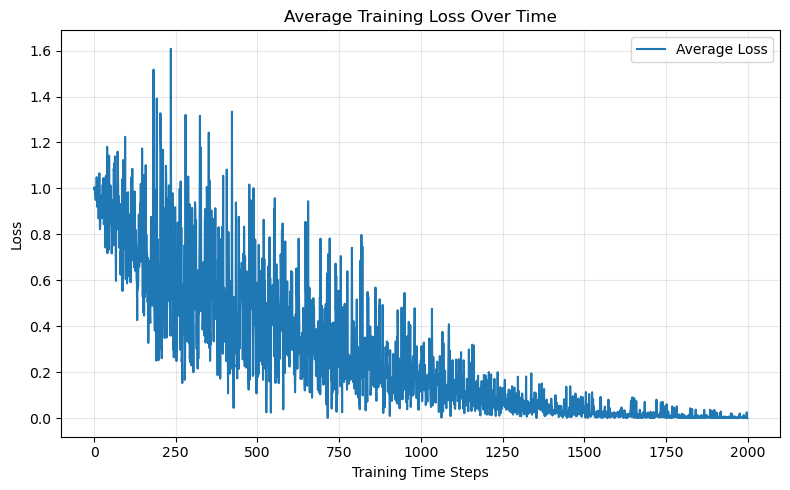

In [7]:
import matplotlib.pyplot as plt

# Plot the average loss across all seeds during training
if isinstance(results, tuple):
    results = results[1]
losses = results["train"]["losses"]  # shape: (seeds_n, training_steps)
avg_loss = losses.mean(axis=0)
plt.figure(figsize=(8, 5))
plt.plot(avg_loss, label='Average Loss')
plt.xlabel("Training Time Steps")
plt.ylabel("Loss")
plt.title("Average Training Loss Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


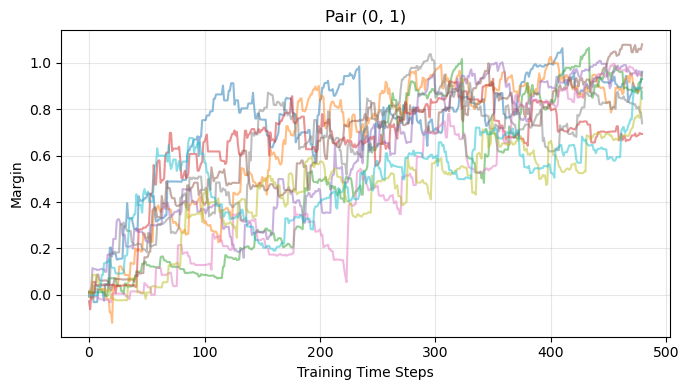

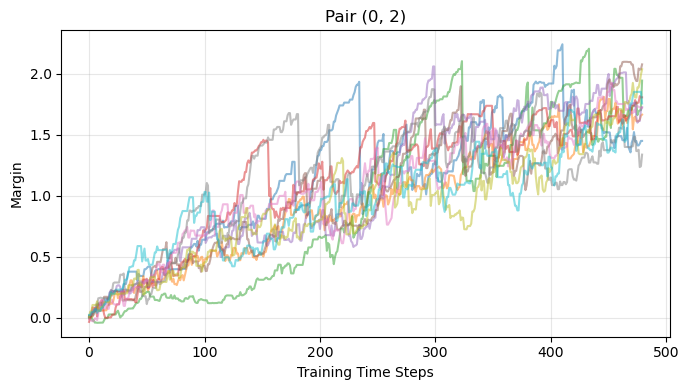

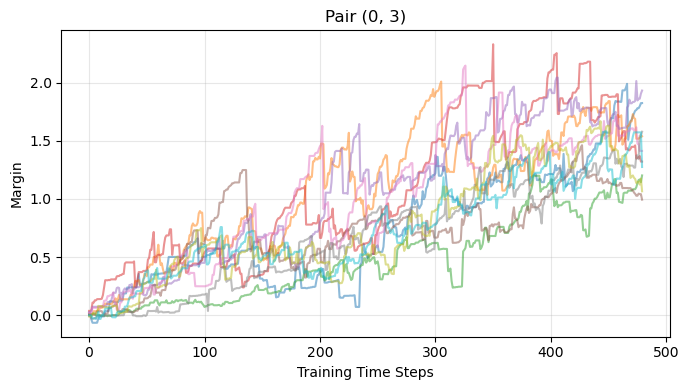

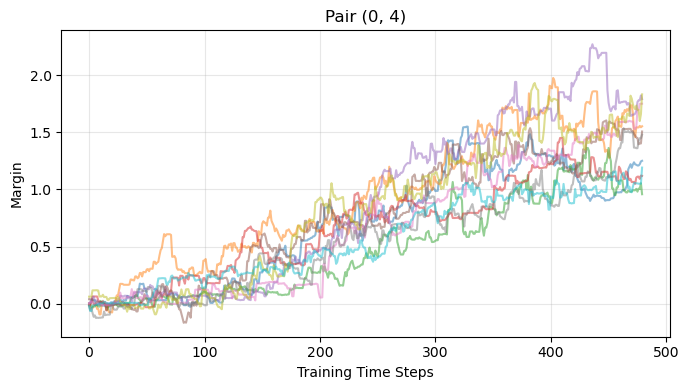

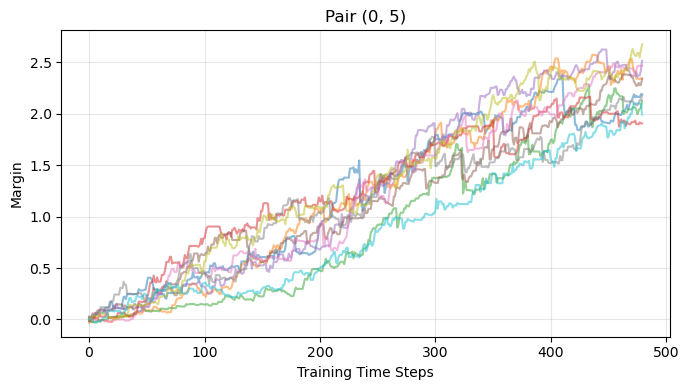

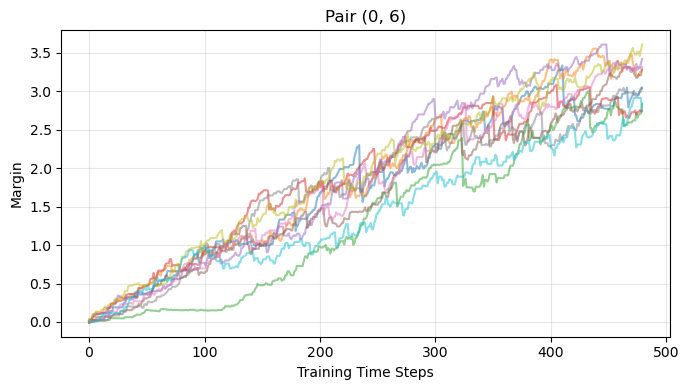

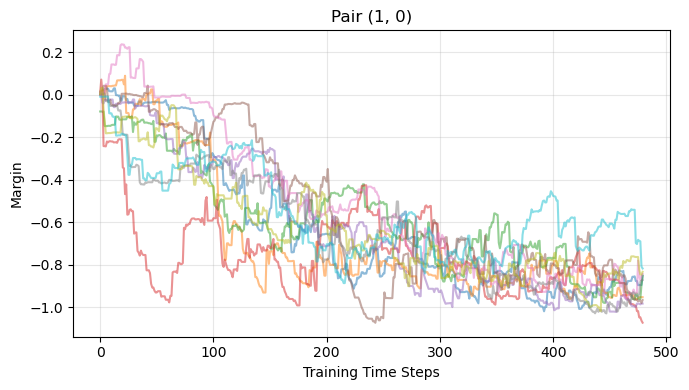

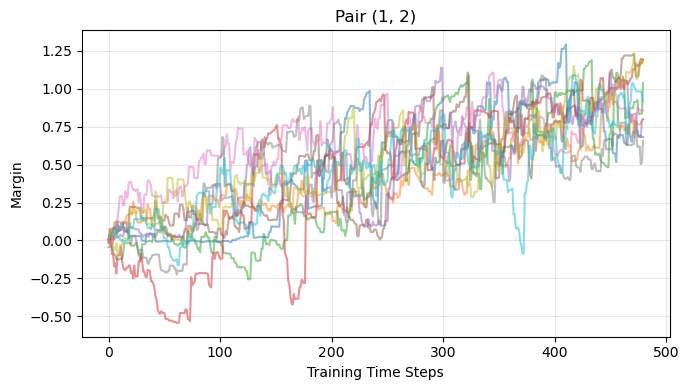

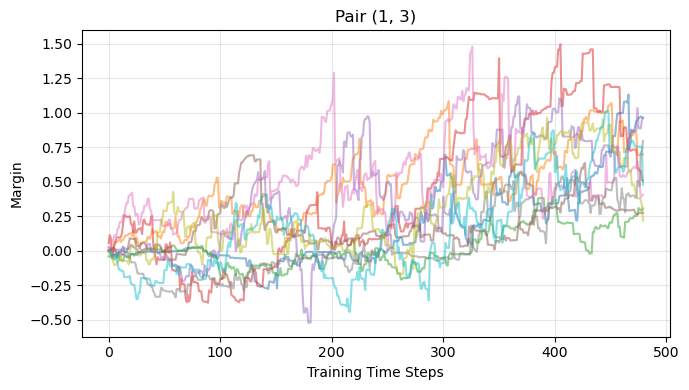

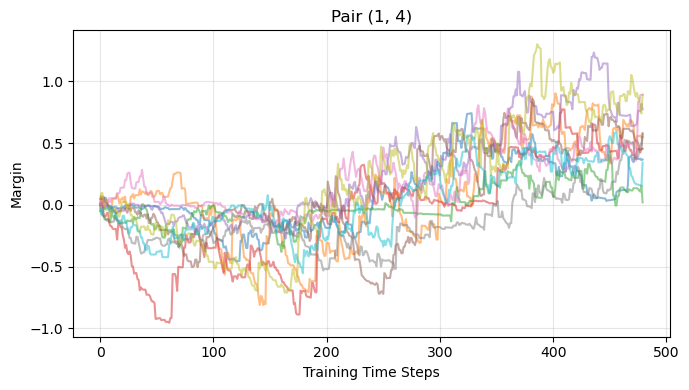

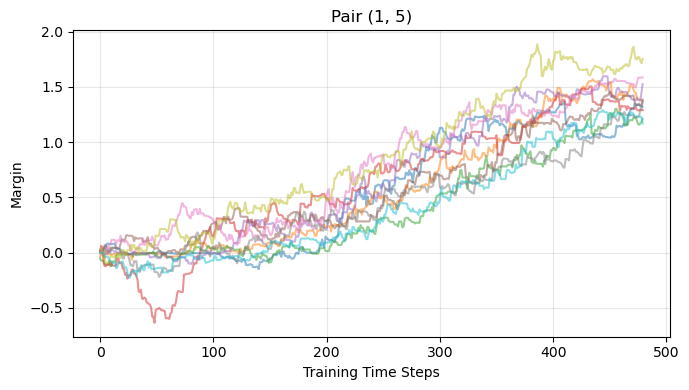

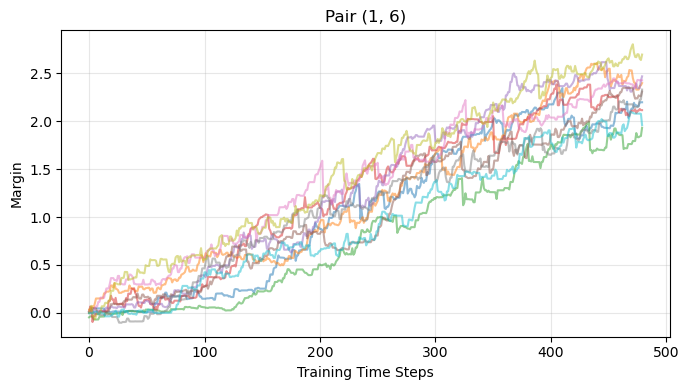

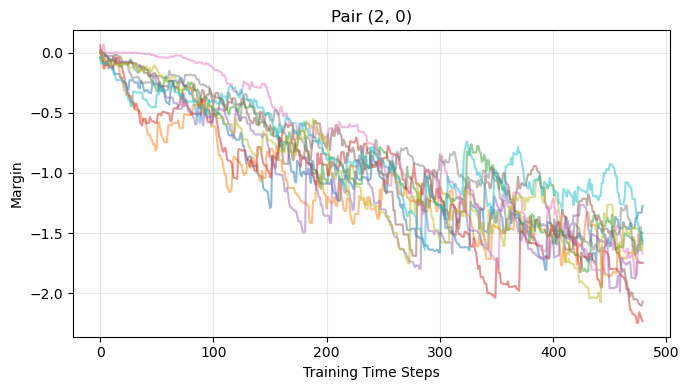

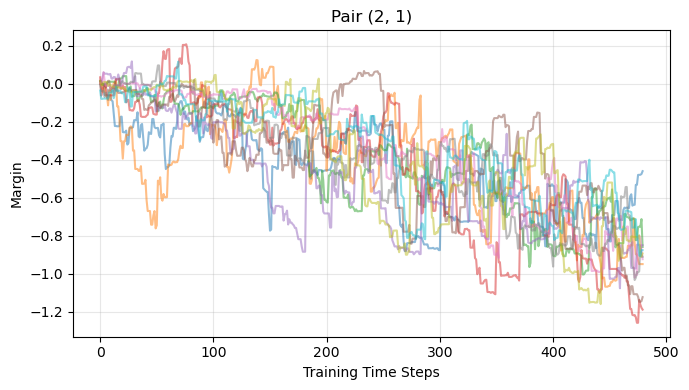

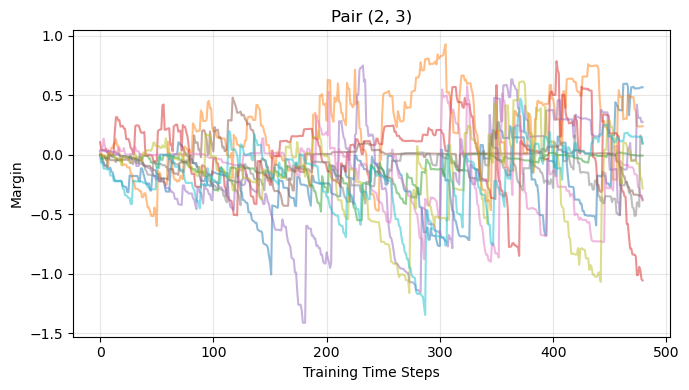

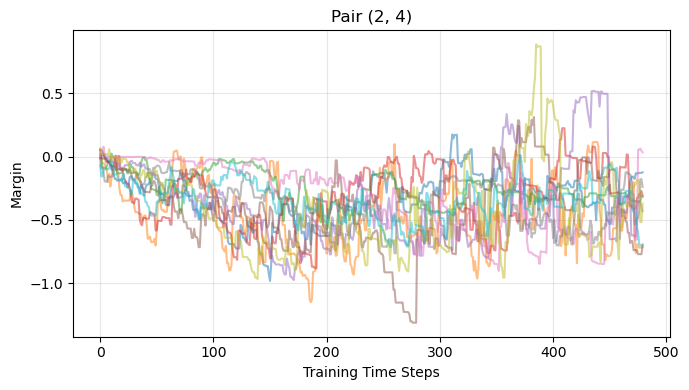

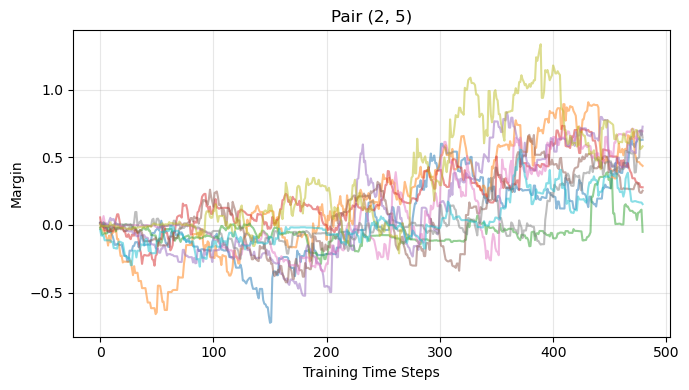

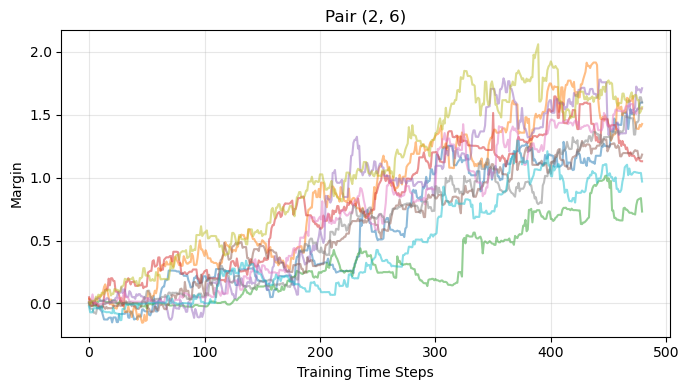

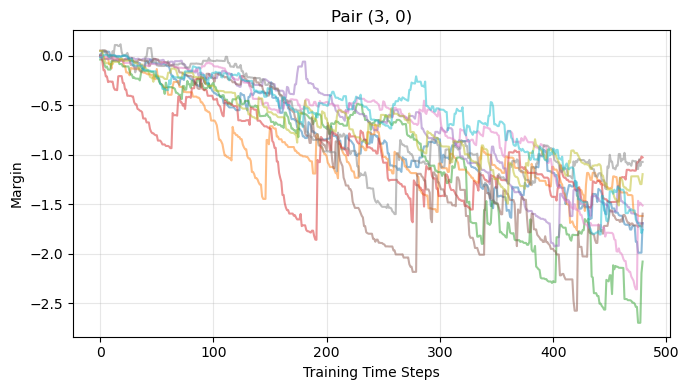

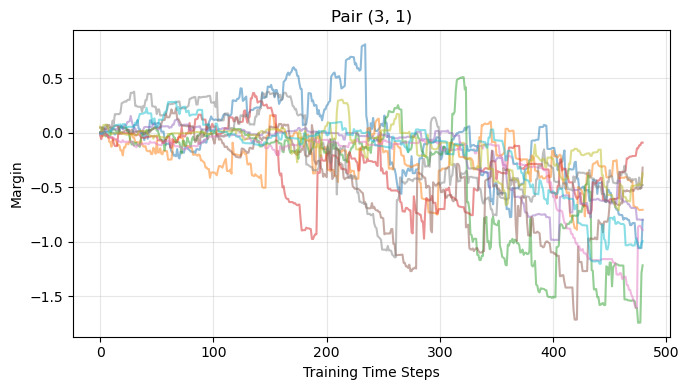

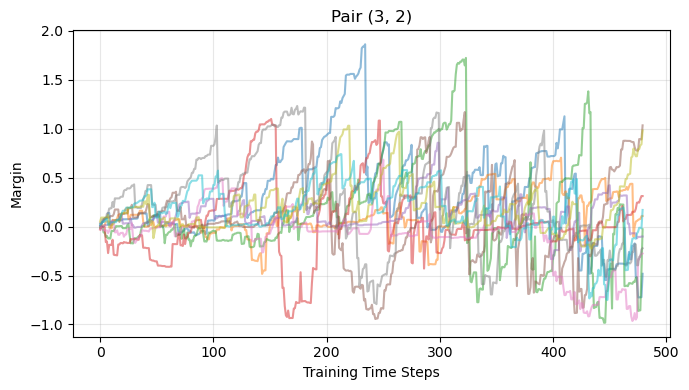

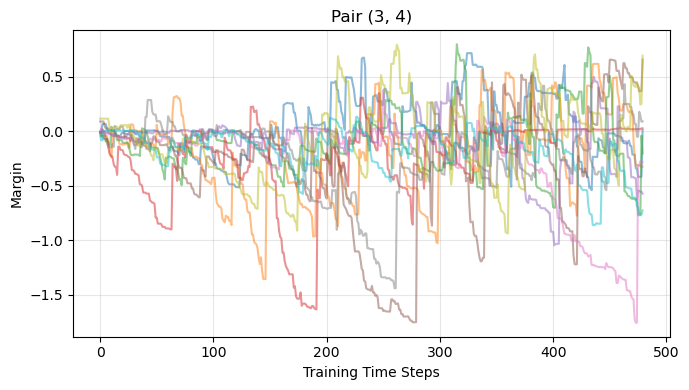

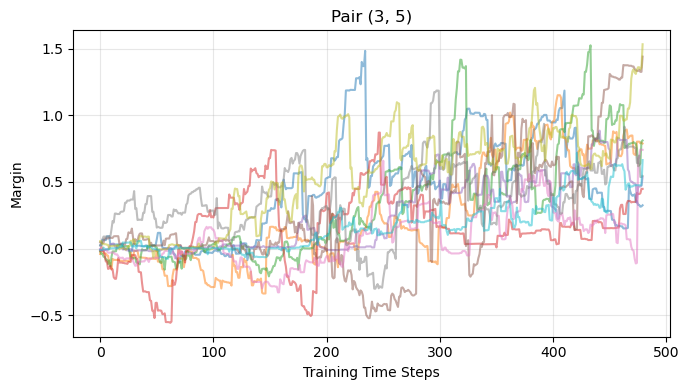

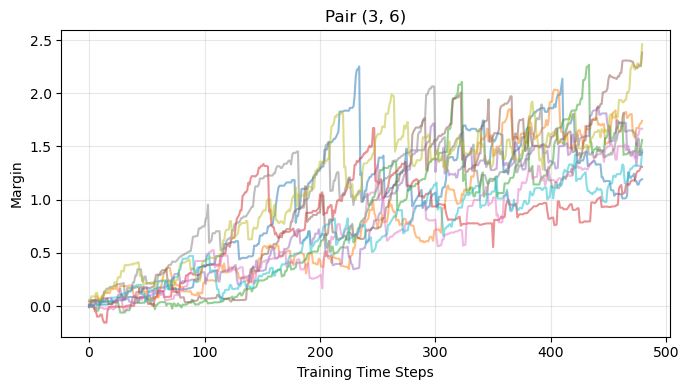

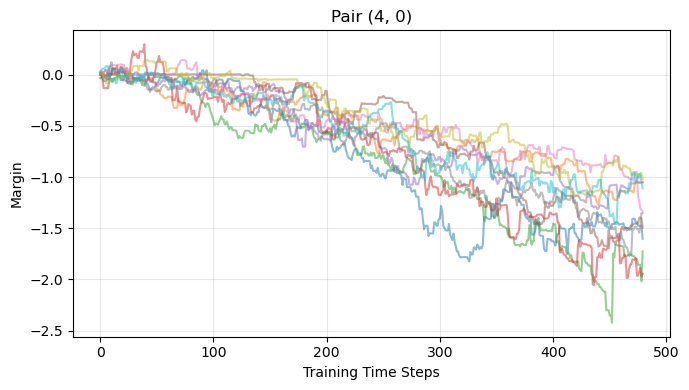

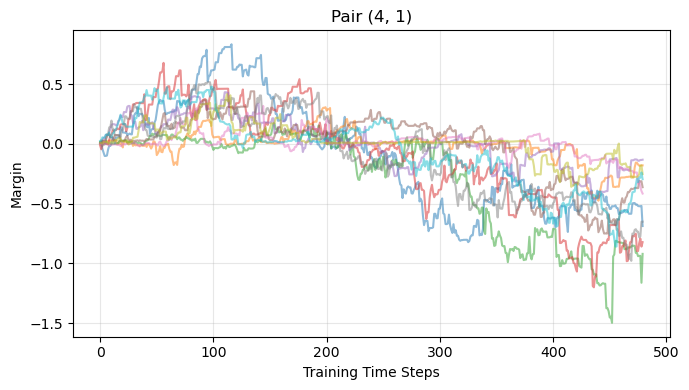

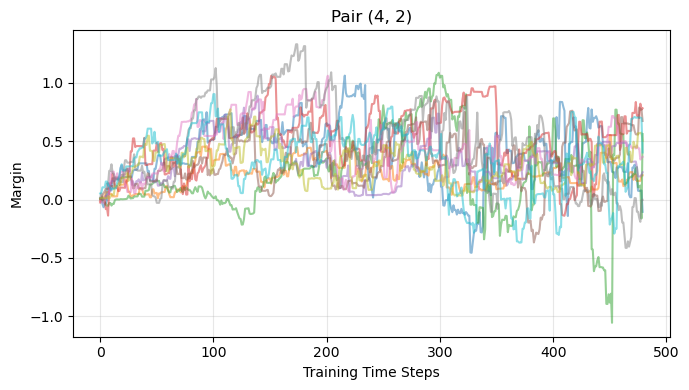

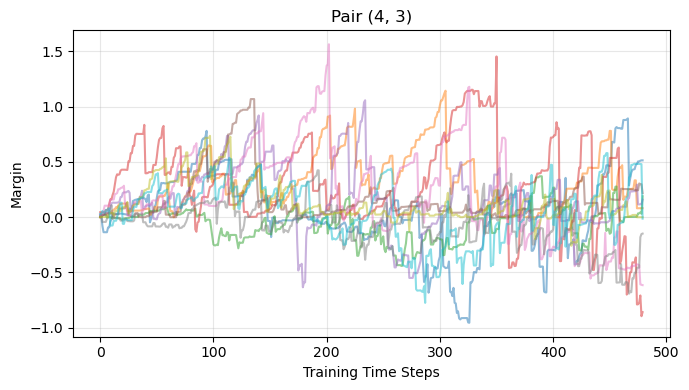

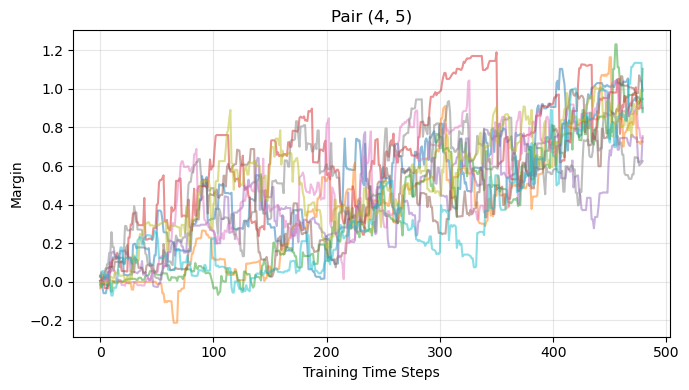

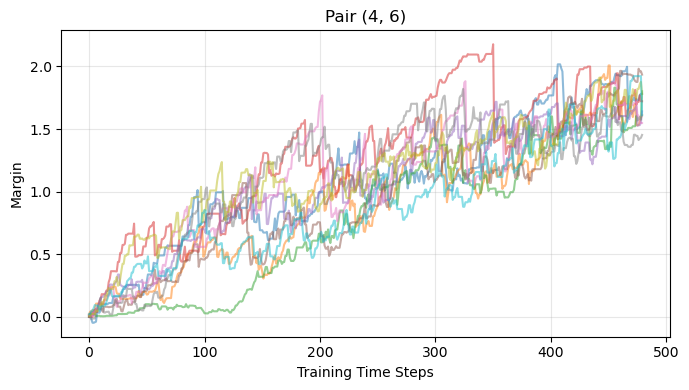

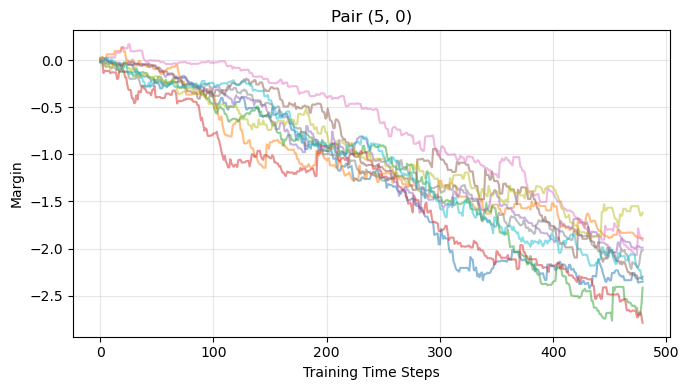

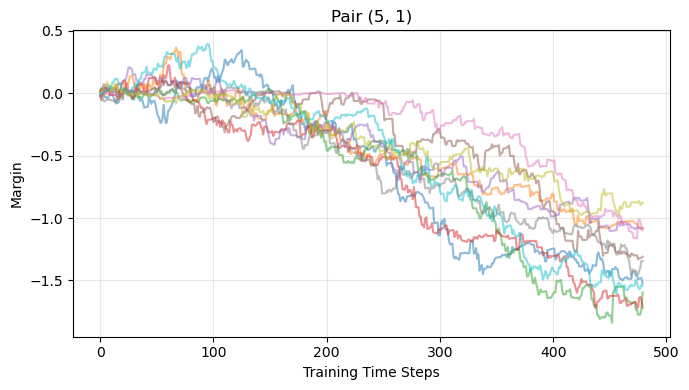

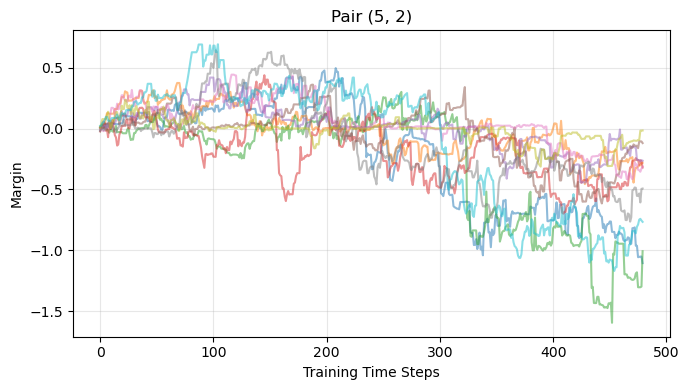

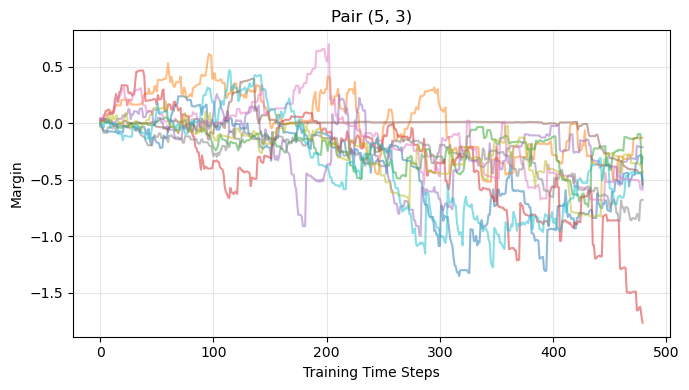

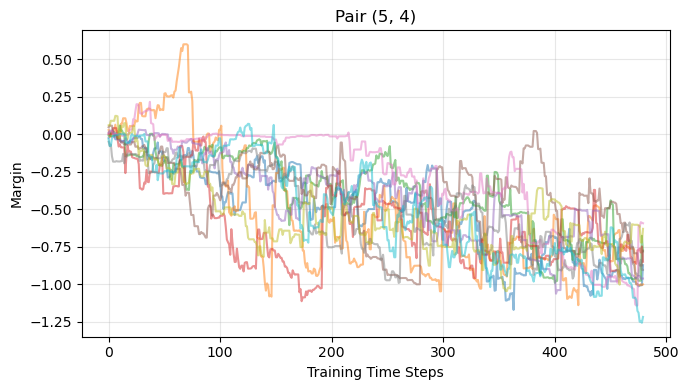

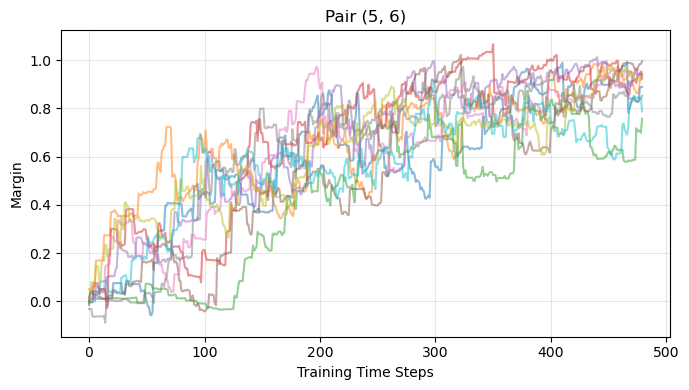

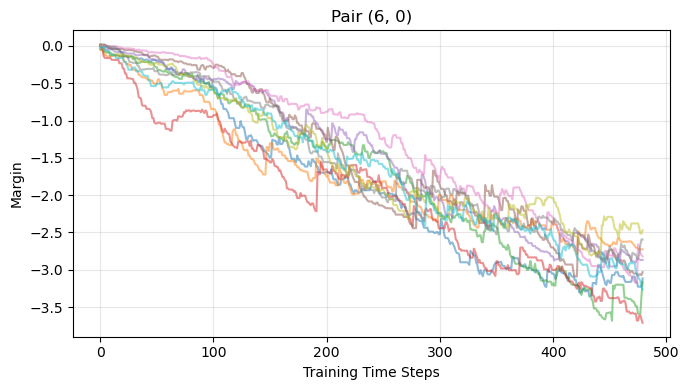

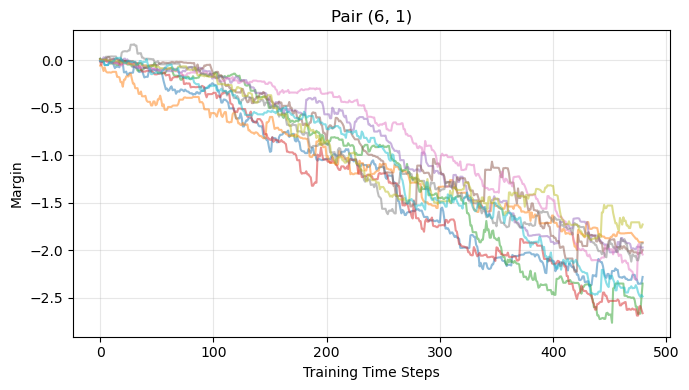

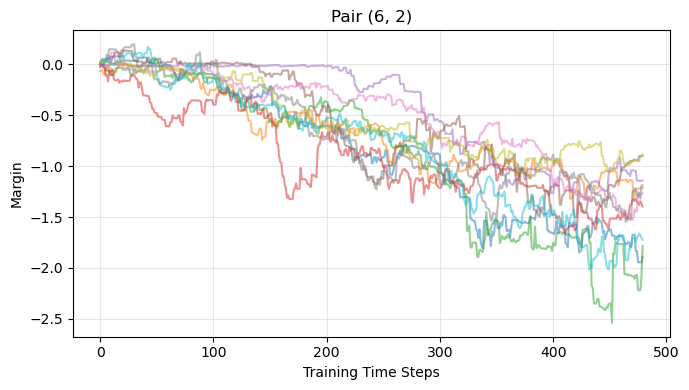

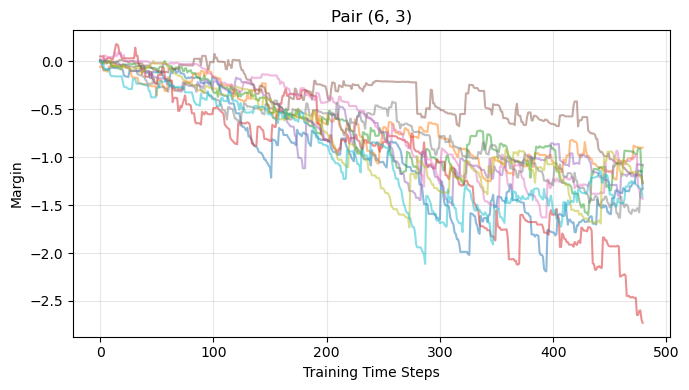

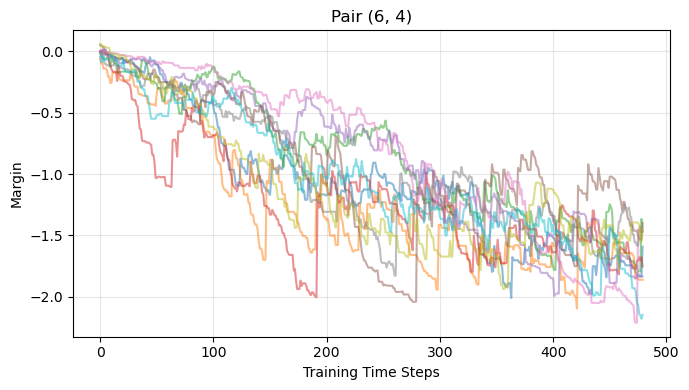

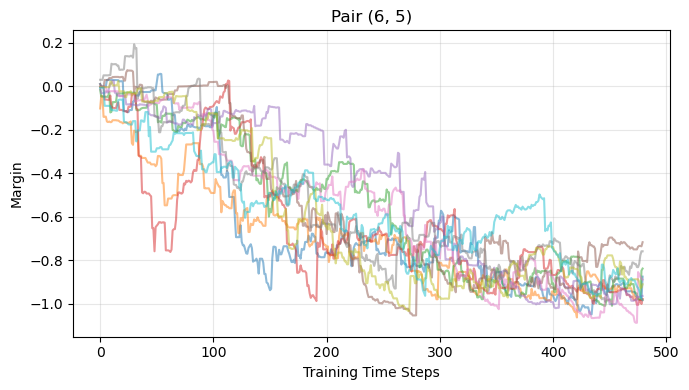

In [8]:
# Plot for every possible pair (i, j) in different figures
# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]
seeds_n = training_progress.shape[0]
items_n = training_progress.shape[2]

for i in range(items_n):
    for j in range(items_n):
        if i == j:
            continue  # skip diagonal if desired
        plt.figure(figsize=(7,4))
        for seed in range(seeds_n):
            plt.plot(training_progress[seed, :480, i, j], alpha=0.5)
        plt.xlabel("Training Time Steps")
        plt.ylabel("Margin")
        plt.title(f"Pair ({i}, {j})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Average margin grid (across seeds and final time):
[[ 0.02520823  1.0087206   1.81825457  1.48040162  1.71316437  2.45761305
   3.38926768]
 [-1.00975961  0.05702994  1.0116176   0.65573445  0.63164881  1.50233616
   2.50537553]
 [-1.94503068 -1.00983202 -0.2109817   0.93292997 -0.9550072   0.3496945
   1.46196085]
 [-1.59577562 -0.66671324 -0.9397916  -0.09697568  0.95502461  0.68327512
   1.65826674]
 [-1.35784453 -0.29229256  0.950821   -0.93675396  0.07175282  1.0075446
   1.84170699]
 [-2.3853565  -1.41506249 -0.56454066 -0.79771693 -1.00293141 -0.06255588
   1.00527376]
 [-3.23042305 -2.2678845  -1.54492294 -1.57468935 -1.8352443  -1.00176286
  -0.01111385]]


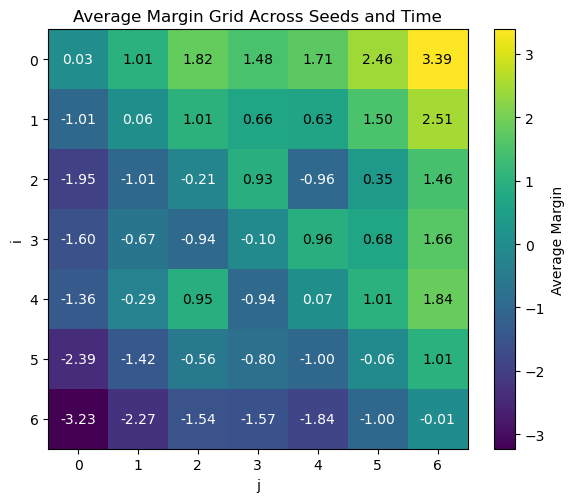

In [9]:
# Compute the average margin across seeds and time for each (i, j) pair
# Resulting in a grid of shape (items_n, items_n)
t_final = training_progress.shape[1] - 1
average_margin_grid = training_progress[:, t_final, :, :].mean(axis=0)
print("Average margin grid (across seeds and final time):")
print(average_margin_grid)

# Plot the average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im = plt.imshow(average_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label="Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.title("Average Margin Grid Across Seeds and Time")

# Add values in each cell
for i in range(average_margin_grid.shape[0]):
    for j in range(average_margin_grid.shape[1]):
        value = average_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()






Corrected average margin grid:
[[ 0.02520823  1.0087206   1.81825457  1.48040162  1.71316437  2.45761305
   3.38926768]
 [ 1.00975961  0.05702994  1.0116176   0.65573445  0.63164881  1.50233616
   2.50537553]
 [ 1.94503068  1.00983202 -0.2109817   0.93292997  0.9550072   0.3496945
   1.46196085]
 [ 1.59577562  0.66671324  0.9397916  -0.09697568  0.95502461  0.68327512
   1.65826674]
 [ 1.35784453  0.29229256  0.950821    0.93675396  0.07175282  1.0075446
   1.84170699]
 [ 2.3853565   1.41506249  0.56454066  0.79771693  1.00293141 -0.06255588
   1.00527376]
 [ 3.23042305  2.2678845   1.54492294  1.57468935  1.8352443   1.00176286
  -0.01111385]]


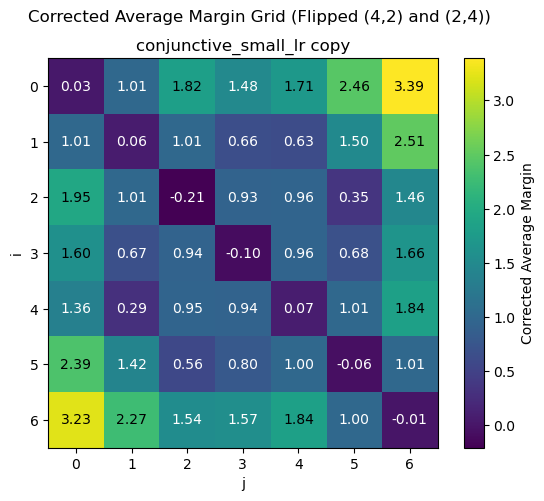

In [10]:
# Create a "correct" average margin grid where (4,2) and (2,4) entries are multiplied by -1, as well as if i>j
correct_margin_grid = average_margin_grid.copy()
correct_margin_grid[4, 2] *= -1
correct_margin_grid[2, 4] *= -1
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        if i>j and ( (i != 2 and j != 4) or (i != 4 and j != 2) ):
            correct_margin_grid[i,j] *= -1

print("Corrected average margin grid:")
print(correct_margin_grid)

# Plot the corrected average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im_correct = plt.imshow(correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_correct, label="Corrected Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Corrected Average Margin Grid (Flipped (4,2) and (2,4))")
plt.title("conjunctive_small_lr copy")

# Add values in each cell
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        value = correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()



Sigmoid of corrected average margin grid:
[[0.50630172 0.73276969 0.86035656 0.81463324 0.84724627 0.9211164
  0.96736744]
 [0.7329731  0.51425362 0.7333366  0.65830154 0.65286323 0.81792265
  0.92451781]
 [0.87490378 0.73298727 0.44744936 0.71766933 0.72212105 0.58654349
  0.8118324 ]
 [0.83142714 0.66076681 0.71905756 0.47577506 0.72212454 0.66446928
  0.8400052 ]
 [0.79540915 0.5725573  0.72128026 0.71844351 0.51793051 0.73253935
  0.86315047]
 [0.91570383 0.8045632  0.63750251 0.6894859  0.73163454 0.48436613
  0.7320942 ]
 [0.96196324 0.90618209 0.82417924 0.82845108 0.86238529 0.73140504
  0.49722157]]


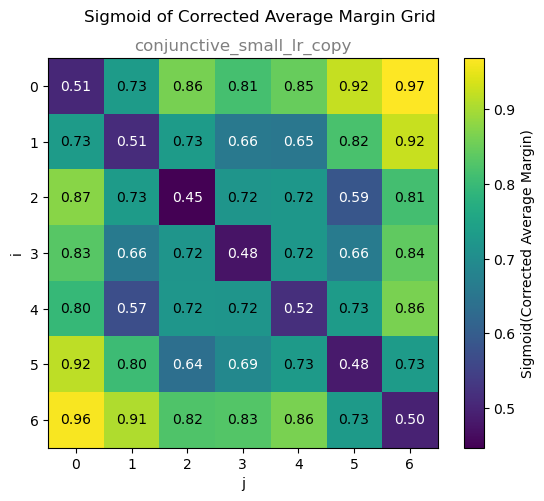

In [11]:
# Compute the sigmoid of the corrected average margin grid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid_correct_margin_grid = sigmoid(correct_margin_grid)

print("Sigmoid of corrected average margin grid:")
print(sigmoid_correct_margin_grid)

# Plot the sigmoid margin grid as a heatmap with values in each cell
plt.figure(figsize=(6, 5))
im_sigmoid_correct = plt.imshow(sigmoid_correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_sigmoid_correct, label="Sigmoid(Corrected Average Margin)")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Sigmoid of Corrected Average Margin Grid")
plt.title("conjunctive_small_lr_copy", color='gray')

# Add values in each cell
for i in range(sigmoid_correct_margin_grid.shape[0]):
    for j in range(sigmoid_correct_margin_grid.shape[1]):
        value = sigmoid_correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_sigmoid_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()


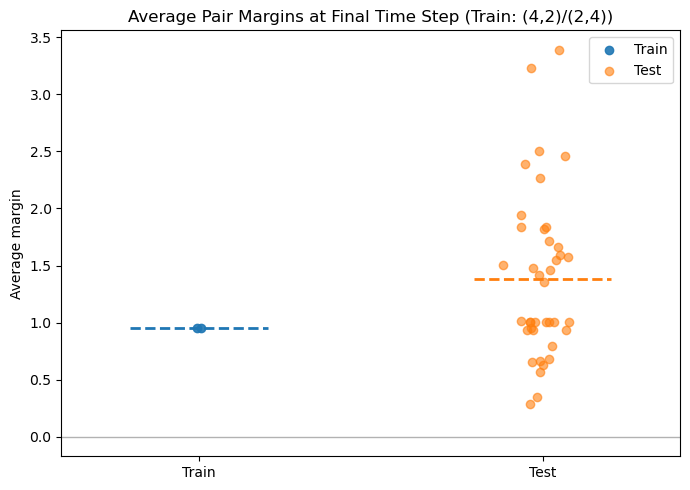

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Set your training pair (ensure p, q are defined as desired)
p, q = 4, 2

items_n = correct_margin_grid.shape[0]

# Masks: only (p,q) and (q,p) are training; test = all other off-diagonals
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

train_vals = correct_margin_grid[train_mask]
test_vals = correct_margin_grid[test_mask]

# Jittered x-positions for scatter
rng = np.random.default_rng(0)
x_train = rng.normal(loc=0, scale=0.05, size=train_vals.size)
x_test  = rng.normal(loc=1, scale=0.05, size=test_vals.size)

plt.figure(figsize=(7, 5))
plt.scatter(x_train, train_vals, color='C0', alpha=0.9, label='Train')
plt.scatter(x_test,  test_vals,  color='C1', alpha=0.6, label='Test')

# Optional: overlay means
plt.hlines(train_vals.mean(), -0.2, 0.2, colors='C0', linestyles='--', linewidth=2)
plt.hlines(test_vals.mean(),  0.8,  1.2, colors='C1', linestyles='--', linewidth=2)

plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('Average margin')
plt.title(f'Average Pair Margins at Final Time Step (Train: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.4, 1.4)
plt.legend()
plt.tight_layout()
plt.show()

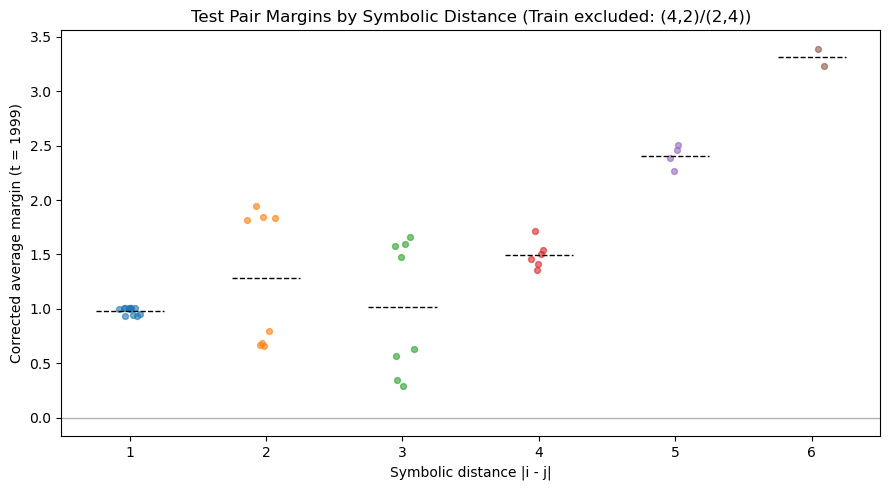

In [13]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|
# Assumes: correct_margin_grid, t_final, p, q are defined as above

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Exclude diagonal and training pair (p,q)/(q,p)
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(1, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, label=None)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(1, items_n), [str(d) for d in range(1, items_n)])
plt.xlabel('Symbolic distance |i - j|')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train excluded: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

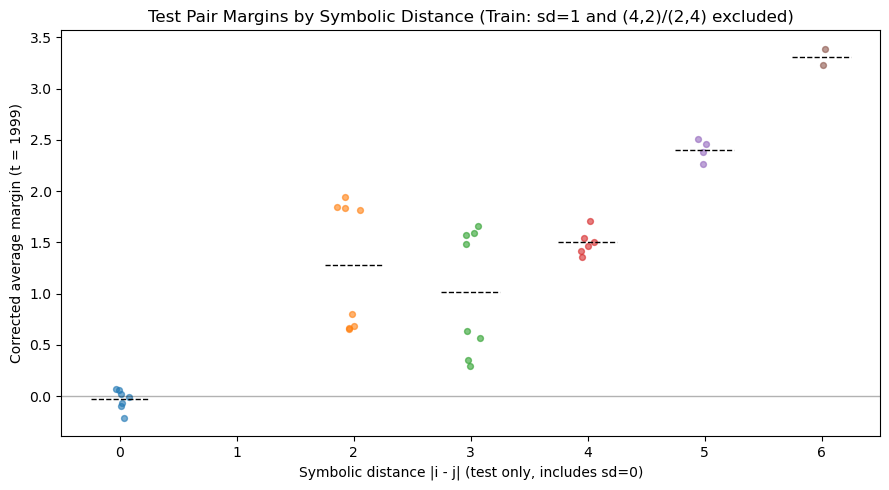

In [14]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|, including sd=0
# Assumes: correct_margin_grid, t_final, p, q are defined

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Training = all sd==1 pairs + the special pair (p,q)/(q,p)
training_mask = (dist_mat == 1)
training_mask[p, q] = True
training_mask[q, p] = True

# Test = everything else (including diagonal sd=0)
test_mask = ~training_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (test only, includes sd=0)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train: sd=1 and ({p},{q})/({q},{p}) excluded)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

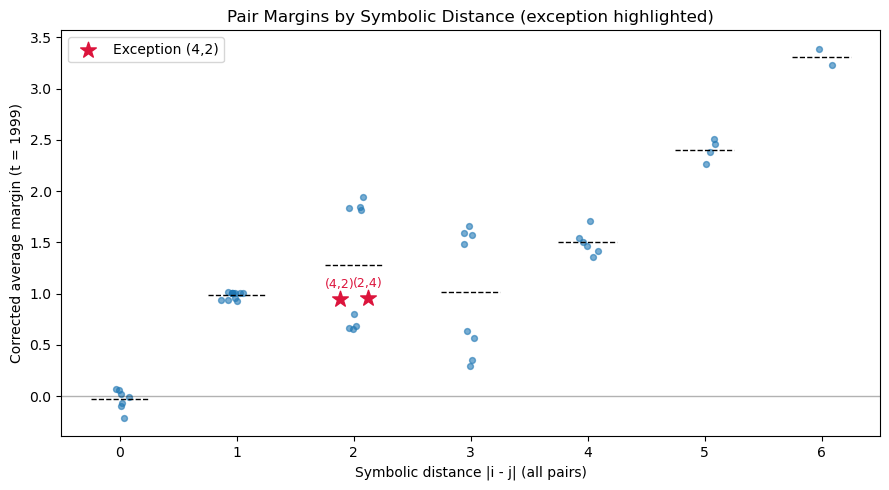

In [15]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) with a distinct color and label.

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = correct_margin_grid[p, q]
y_qp = correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

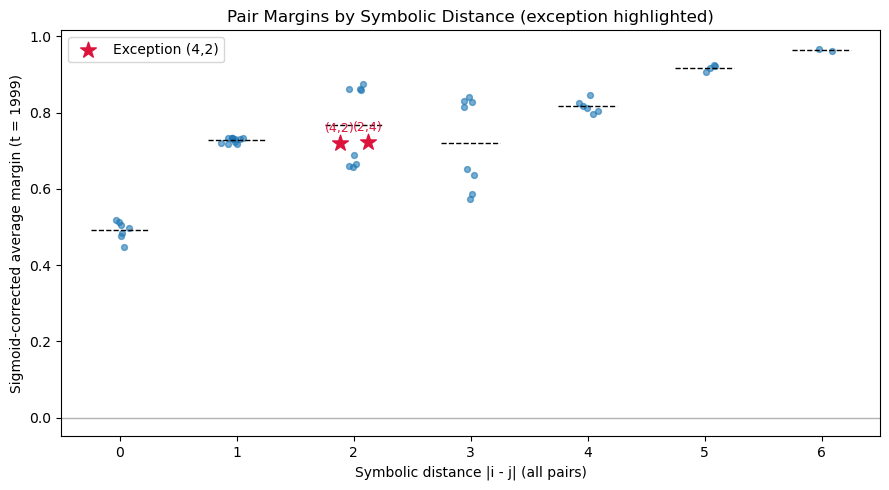

In [16]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) using sigmoid_correct_margin_grid.

import numpy as np
import matplotlib.pyplot as plt

items_n = sigmoid_correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = sigmoid_correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = sigmoid_correct_margin_grid[p, q]
y_qp = sigmoid_correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Sigmoid-corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import csv

# Extract training pair results and save to CSV
# We'll save the average margin over seeds for each pair (i, j) at each time step

# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]  # shape: (seeds_n, time_steps, items_n, items_n)
seeds_n, time_steps, items_n, _ = training_progress.shape

# Prepare CSV header
header = ["time_step", "i", "j"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_margin", "std_margin"]

rows = []
for i in range(items_n):
    for j in range(items_n):
        for t in range(time_steps):
            margins = training_progress[:, t, i, j]
            mean_margin = margins.mean()
            std_margin = margins.std()
            row = [t, i, j] + list(margins) + [mean_margin, std_margin]
            rows.append(row)

# Write to CSV
# 'network' here refers to a variable defined earlier in the notebook, not to the class 'nellinetwork'.
csv_filename = f"training_pair_margins_conjunctive_small_lr_copy.csv"
with open(csv_filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"Training pair results saved to {csv_filename}")

print()


Training pair results saved to training_pair_margins_conjunctive_small_lr_copy.csv



In [18]:
import pandas as pd

# Read the CSV file with training pair margins
df = pd.read_csv(csv_filename)

# Display the first few rows to verify extraction
print("Extracted results from CSV:")
print(df.head())

# Now 'df' contains the extracted results and can be used for further analysis or plotting


Extracted results from CSV:
   time_step  i  j    seed_0    seed_1    seed_2    seed_3    seed_4  \
0          0  0  0  0.005648 -0.000220 -0.005039  0.002325 -0.002253   
1          1  0  0  0.005652 -0.000214 -0.005031  0.002322 -0.002263   
2          2  0  0  0.005638 -0.000219 -0.005035  0.004357 -0.004680   
3          3  0  0  0.005626 -0.000222 -0.005043  0.003076 -0.003320   
4          4  0  0  0.005626  0.001752 -0.008073  0.003072 -0.003317   

     seed_5    seed_6    seed_7    seed_8    seed_9  mean_margin  std_margin  
0  0.003139  0.007124 -0.000473  0.000605  0.002447     0.001330    0.003425  
1  0.003145  0.007127 -0.000475  0.000603  0.002442     0.001330    0.003425  
2  0.003148  0.007124 -0.000480  0.000607  0.002450     0.001291    0.003856  
3  0.003153  0.007128 -0.000486 -0.003860  0.002461     0.000851    0.003903  
4  0.003146  0.007123 -0.000490 -0.010004  0.002448     0.000128    0.005358  


Figure out keyerror on t issue

In [19]:
import numpy as np

print("Columns in DataFrame:", df.columns.tolist())

# Try to find the correct time, i, j column names
# The original code expects 't', but the CSV uses 'time_step'
# Let's map accordingly
col_map = {}
for col in df.columns:
    if col.lower() in ['t', 'time', 'time_step']:
        col_map['t'] = col
    if col.lower() == 'i':
        col_map['i'] = col
    if col.lower() == 'j':
        col_map['j'] = col

# Use mapped column names
t_col = col_map.get('t', 'time_step')
i_col = col_map.get('i', 'i')
j_col = col_map.get('j', 'j')

df_sorted = df.sort_values([t_col, i_col, j_col]).reset_index(drop=True)

# The number of margin columns is seeds_n
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
seeds_n = len(margin_cols)
time_steps = df[t_col].max() + 1  # assumes t is 0-based and contiguous
items_n = max(df[i_col].max(), df[j_col].max()) + 1  # assuming 0-based indexing

# Initialize training_progress array
training_progress = np.zeros((seeds_n, time_steps, items_n, items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

Columns in DataFrame: ['time_step', 'i', 'j', 'seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'mean_margin', 'std_margin']


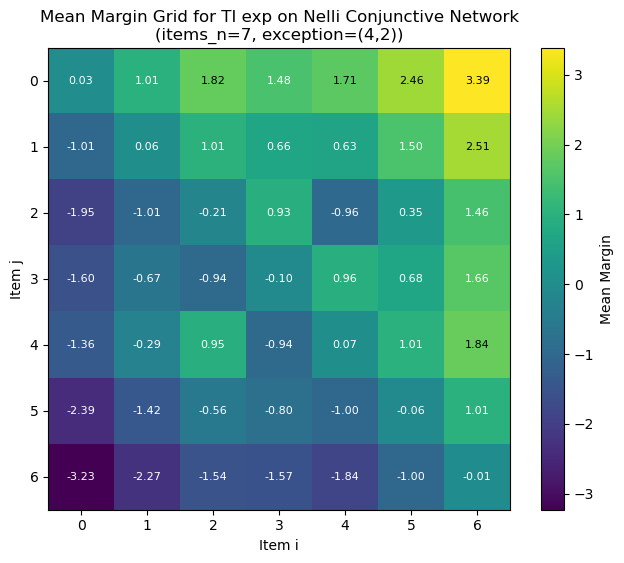

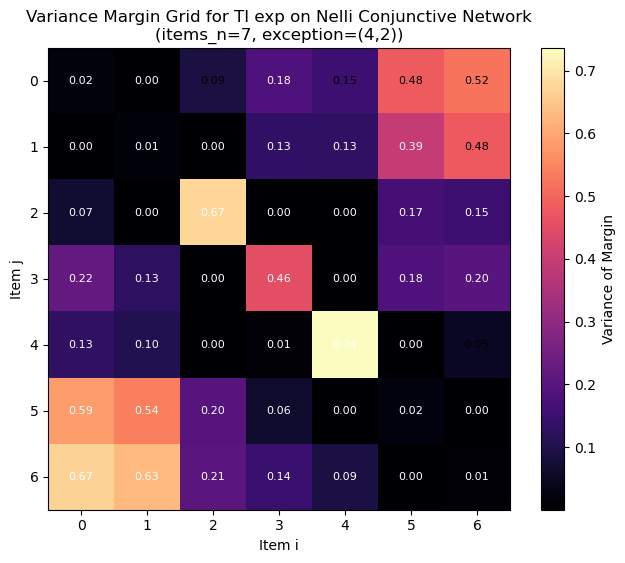

In [20]:
items_per_context = 7
p = 4
q = 2

if isinstance(results, tuple):
    results = results[1]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_progress.shape[1]-1, i, j]
Average_Grid = np.mean(Grid, axis=0)
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))

# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title(f'Variance Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()


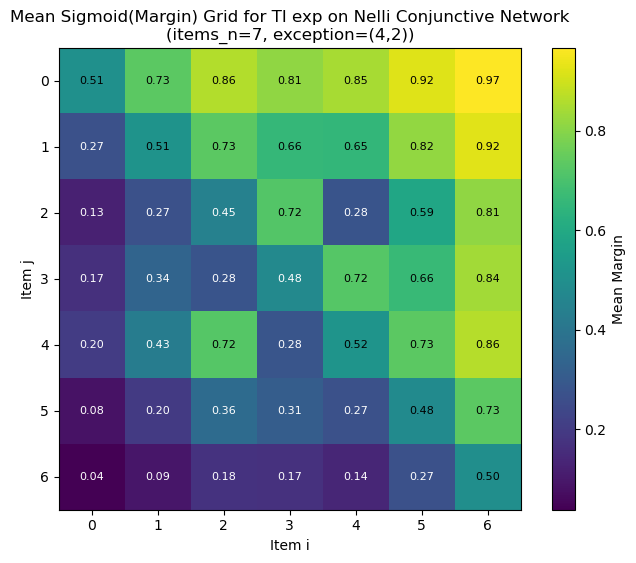

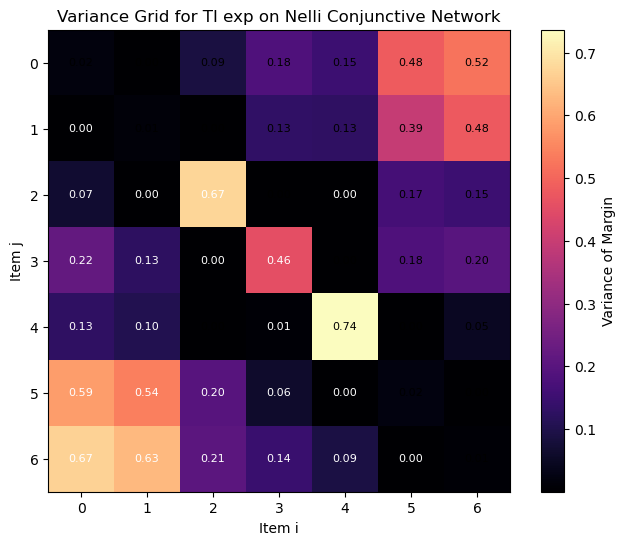

In [21]:
# if isinstance(results, tuple):
    # results = results[1]
# training_progress = results["train"]["training_progress"]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_length - 1, i, j]
Average_Grid = np.mean(Grid, axis=0)
# Apply sigmoid function to Average_Grid
Average_Grid = 1 / (1 + np.exp(-Average_Grid))
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Sigmoid(Margin) Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title('Variance Grid for TI exp on Nelli Conjunctive Network')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()